In [1]:
from typing import Optional
import torch
from torch import nn
from torchaudio import functional as F


class LogMelFilterBanks(nn.Module):
    def __init__(
        self,
        n_fft: int = 400,
        samplerate: int = 16000,
        hop_length: int = 160,
        n_mels: int = 80,
        pad_mode: str = 'reflect',
        power: float = 2.0,
        normalize_stft: bool = False,
        onesided: bool = True,
        center: bool = True,
        return_complex: bool = True,
        f_min_hz: float = 0.0,
        f_max_hz: Optional[float] = None,
        norm_mel: Optional[str] = None,
        mel_scale: str = 'htk'
    ):
        super(LogMelFilterBanks, self).__init__()
        self.n_fft = n_fft
        self.samplerate = samplerate
        self.window_length = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.pad_mode = pad_mode
        self.power = power
        self.normalize_stft = normalize_stft
        self.onesided = onesided
        self.center = center
        self.return_complex = return_complex

        self.f_min_hz = f_min_hz
        self.f_max_hz = f_max_hz
        self.norm_mel = norm_mel
        self.mel_scale = mel_scale

        self.window = torch.hann_window(self.window_length)
        self.mel_fbanks = self._init_melscale_fbanks()

    def _init_melscale_fbanks(self):
        return F.melscale_fbanks(
            n_freqs=self.n_fft // 2 + 1,
            n_mels=self.n_mels,
            f_min=self.f_min_hz,
            f_max=self.f_max_hz or self.samplerate / 2.0,
            sample_rate=self.samplerate,
            norm=self.norm_mel,
            mel_scale=self.mel_scale
        )

    def spectrogram(self, x):
        return torch.stft(
            x,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.window_length,
            window=self.window.to(x.device),
            center=self.center,
            pad_mode=self.pad_mode,
            normalized=self.normalize_stft,
            onesided=self.onesided,
            return_complex=self.return_complex
        )

    def forward(self, x):
        spec = self.spectrogram(x)
        spec_power = spec.abs() ** self.power
        spec_power = spec_power.permute(0, 2, 1)
        mel_spec = torch.matmul(spec_power, self.mel_fbanks.to(x.device))
        mel_spec = mel_spec.permute(0, 2, 1)
        log_mel_spec = torch.log(mel_spec + 1e-6)#борьба с 0 в логарифме 
        return log_mel_spec




In [2]:
import torchaudio
import torchaudio.transforms as T

wav_path = torchaudio.utils.download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
signal, sr = torchaudio.load(wav_path)
print(f'тут мы видим, что сэмпл рейт не подходит --- {sr}')

тут мы видим, что сэмпл рейт не подходит --- 44100


In [3]:
resampler = T.Resample(orig_freq=sr, new_freq=16000)# так мы сменим сэипл рейт
signal = resampler(signal)
sr = 16000
print(sr)  #вот тут уже отлично

assert sr == 16000

melspec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, hop_length=160, n_mels=80)(signal)

logmelbanks = LogMelFilterBanks()(signal)

assert logmelbanks.shape == torch.log(melspec + 1e-6).shape
assert torch.allclose(logmelbanks, torch.log(melspec + 1e-6), atol=1e-4)

16000


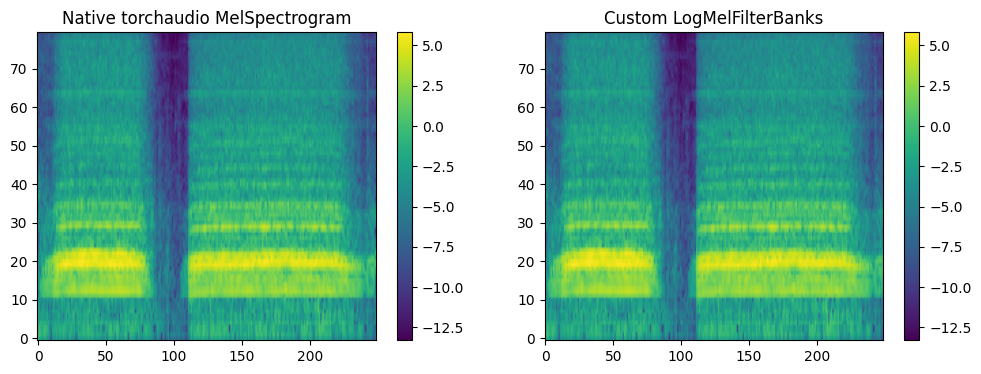

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Native torchaudio MelSpectrogram")
plt.imshow(torch.log(melspec[0] + 1e-6).numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Custom LogMelFilterBanks")
plt.imshow(logmelbanks[0].numpy(), aspect='auto', origin='lower')
plt.colorbar()
plt.show()


### вроде вполне себе похожи

### Теперь шаг 2 - моделька классификатор

In [5]:
import torch
from torchaudio.datasets import SPEECHCOMMANDS
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score
from ptflops import get_model_complexity_info

def load_and_prepare(subset):
    target_length = 16000
    dataset = SPEECHCOMMANDS(".", download=True, subset=subset)
    audio_samples = []
    class_labels = []
    for waveform, sample_rate, label, *_ in dataset:
        if label == "yes":
            class_labels.append(1)
        elif label == "no":
            class_labels.append(0)
        else:
            continue
        if waveform.shape[1] < target_length:
            pad_amount = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        else:
            waveform = waveform[:, :target_length]
        audio_samples.append(waveform)
    all_audio = torch.cat(audio_samples, dim=0).unsqueeze(1)
    all_labels = torch.tensor(class_labels)

    return TensorDataset(all_audio, all_labels)


In [6]:
train_loader = DataLoader(load_and_prepare("training"), batch_size=64, shuffle=True)
val_loader = DataLoader(load_and_prepare("validation"), batch_size=64)
test_loader = DataLoader(load_and_prepare("testing"), batch_size=64)

In [7]:
class Model(nn.Module):
    def __init__(self, n_mels=80, emb_dim=128, hidden=32, kernel=3, groups=1):
        super().__init__()
        
        self.feature_extractor = LogMelFilterBanks(n_mels=n_mels)
        
        self.body = nn.Sequential(
            nn.Conv1d(n_mels, hidden, kernel, groups=groups, padding=1),  
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.MaxPool1d(2),
            nn.Conv1d(hidden, hidden, kernel, groups=groups, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.MaxPool1d(2),
            nn.Conv1d(hidden, hidden, kernel, groups=groups, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden),
            nn.AdaptiveAvgPool1d(1)
        )
        self.emb_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden, emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(emb_dim, 2)

    def forward(self, X):
        X = X.squeeze(1)
        x = self.feature_extractor(X)
        x = self.body(x)
        embeddings = self.emb_layer(x)
        logits = self.classifier(embeddings)
        return logits, embeddings


## Перебор мел-банков

Set n_mels = 20 ----- training
Epoch 1, Loss: 0.2085, Val Acc: 0.9763, Time: 0.63s
Epoch 2, Loss: 0.0868, Val Acc: 0.9863, Time: 0.44s
Epoch 3, Loss: 0.0541, Val Acc: 0.9888, Time: 0.44s
Epoch 4, Loss: 0.0456, Val Acc: 0.9813, Time: 0.43s
Epoch 5, Loss: 0.0431, Val Acc: 0.9738, Time: 0.44s
Epoch 6, Loss: 0.0418, Val Acc: 0.9888, Time: 0.44s
Epoch 7, Loss: 0.0352, Val Acc: 0.9838, Time: 0.44s
Epoch 8, Loss: 0.0319, Val Acc: 0.9950, Time: 0.43s
Epoch 9, Loss: 0.0262, Val Acc: 0.9875, Time: 0.44s
Epoch 10, Loss: 0.0226, Val Acc: 0.9913, Time: 0.45s
Set n_mels=20 ------- test accuracy: 0.9976
Set n_mels = 40 ----- training
Epoch 1, Loss: 0.1750, Val Acc: 0.9801, Time: 0.41s
Epoch 2, Loss: 0.0797, Val Acc: 0.9701, Time: 0.41s
Epoch 3, Loss: 0.0549, Val Acc: 0.9788, Time: 0.41s
Epoch 4, Loss: 0.0424, Val Acc: 0.9875, Time: 0.39s
Epoch 5, Loss: 0.0458, Val Acc: 0.9776, Time: 0.41s
Epoch 6, Loss: 0.0390, Val Acc: 0.9888, Time: 0.41s
Epoch 7, Loss: 0.0318, Val Acc: 0.9801, Time: 0.40s
Epoch 8, 

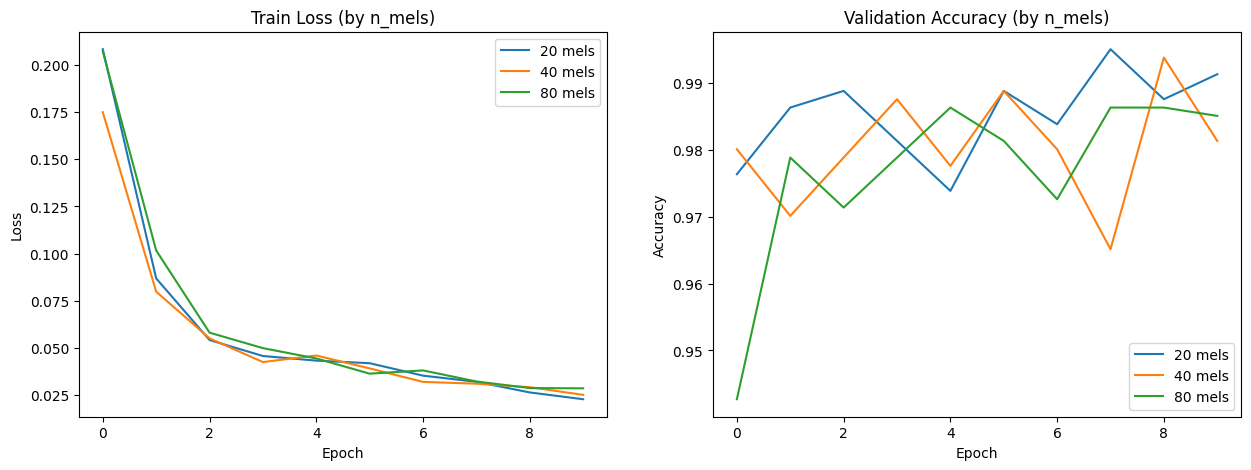

In [8]:
device = 'cuda'
n_mels_list = [20, 40, 80]
experiment_1_results = {}

for n_mels in n_mels_list:
    print(f"Set n_mels = {n_mels} ----- training")
    model = Model(n_mels=n_mels).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_accuracies = [], []
    for epoch in range(10):  
        model.train()
        losses = []
        start_epoch = time.time()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            logits, _ = model(X)
            loss = torch.nn.functional.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = sum(losses)/len(losses)
        train_losses.append(avg_loss)
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                logits, _ = model(X_val)
                preds = logits.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y_val.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {time.time()-start_epoch:.2f}s")

    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            logits, _ = model(X_test)
            preds = logits.argmax(dim=1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(y_test.numpy())
    test_acc = accuracy_score(test_labels, test_preds)
    print(f"Set n_mels={n_mels} ------- test accuracy: {test_acc:.4f}")
    experiment_1_results[n_mels] = {
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_acc
    }
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for n_mels in n_mels_list:
    axes[0].plot(experiment_1_results[n_mels]['train_losses'], label=f"{n_mels} mels")
    axes[1].plot(experiment_1_results[n_mels]['val_accuracies'], label=f"{n_mels} mels")

axes[0].set_title("Train Loss (by n_mels)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].set_title("Validation Accuracy (by n_mels)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
plt.savefig(f"experiment_n_mels.png", dpi=300) 
plt.show()


Training model with groups = 1
Model(
  18.85 k, 100.000% Params, 1.04 MMac, 38.851% MACs, 
  (feature_extractor): LogMelFilterBanks(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (body): Sequential(
    14.11 k, 74.865% Params, 1.03 MMac, 38.669% MACs, 
    (0): Conv1d(7.71 k, 40.912% Params, 778.91 KMac, 29.123% MACs, 80, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(0, 0.000% Params, 3.23 KMac, 0.121% MACs, )
    (2): BatchNorm1d(64, 0.340% Params, 6.46 KMac, 0.242% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(0, 0.000% Params, 3.23 KMac, 0.121% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(3.1 k, 16.467% Params, 155.2 KMac, 5.803% MACs, 32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU(0, 0.000% Params, 1.6 KMac, 0.060% MACs, )
    (6): BatchNorm1d(64, 0.340% Params, 3.2 KMac, 0.120% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7)

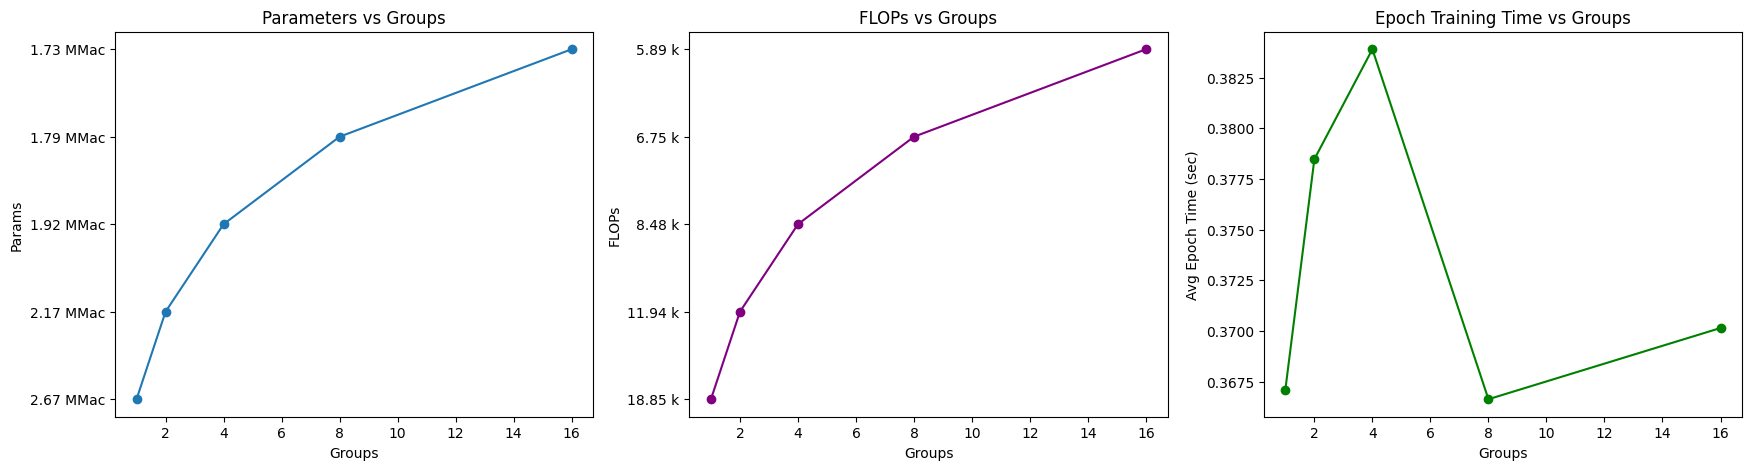

In [9]:
groups_list = [1, 2, 4, 8, 16]
experiment_2_results = {}
for groups in groups_list:
    print(f"Training model with groups = {groups}")
    model = Model(groups=groups).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    params, flops = get_model_complexity_info(model, (1, 16000))
    epoch_times, train_losses, val_accuracies = [], [], []
    for epoch in range(8):
        model.train()
        start_epoch = time.time()
        losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            logits, _ = model(X)
            loss = torch.nn.functional.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        epoch_time = time.time() - start_epoch
        epoch_times.append(epoch_time)
        avg_loss = sum(losses)/len(losses)
        train_losses.append(avg_loss)
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                logits, _ = model(X_val)
                preds = logits.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y_val.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    experiment_2_results[groups] = {
        'epoch_times': epoch_times,
        'avg_epoch_time': np.mean(epoch_times),
        'params': params,
        'flops': flops,
        'val_accuracies': val_accuracies
    }

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

axes[0].plot(groups_list, [experiment_2_results[g]['params'] for g in groups_list], marker='o')
axes[0].set_title("Parameters vs Groups")
axes[0].set_xlabel("Groups")
axes[0].set_ylabel("Params")

axes[1].plot(groups_list, [experiment_2_results[g]['flops'] for g in groups_list], marker='o', color='purple')
axes[1].set_title("FLOPs vs Groups")
axes[1].set_xlabel("Groups")
axes[1].set_ylabel("FLOPs")

axes[2].plot(groups_list, [experiment_2_results[g]['avg_epoch_time'] for g in groups_list], marker='o', color='green')
axes[2].set_title("Epoch Training Time vs Groups")
axes[2].set_xlabel("Groups")
axes[2].set_ylabel("Avg Epoch Time (sec)")
plt.savefig("experiment_groups.png", dpi=300)
plt.show()
